In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Load the residential consumption data
RC = pd.read_csv("Residential_consumption_trends_20240901141207.csv")

# Convert 'Period start' to datetime format
RC['Period start'] = pd.to_datetime(RC['Period start'], format='%d/%m/%y')

# Filter for Lower North Island (LNI) region
RC_LNI = RC[RC['Region'] == 'Lower North Island']

# Split into training and validation sets by '2021-01-01'
split_date = '2021-01-01'
train_LNI = RC_LNI[RC_LNI['Period start'] < split_date]
validation_LNI = RC_LNI[RC_LNI['Period start'] >= split_date]

# Set 'Period start' as the index
train_LNI.set_index('Period start', inplace=True)
validation_LNI.set_index('Period start', inplace=True)

# Select the 'Est. Total consumption (GWh)' column as the target series for analysis
y_train = train_LNI['Est. Total consumption (GWh)']
y_validation = validation_LNI['Est. Total consumption (GWh)']

# Apply 1st order regular differencing (to remove trend)
y_train_diff = y_train.diff().dropna()

# Apply seasonal differencing (assuming monthly data, so period=12)
y_train_diff_seasonal = y_train_diff.diff(12).dropna()

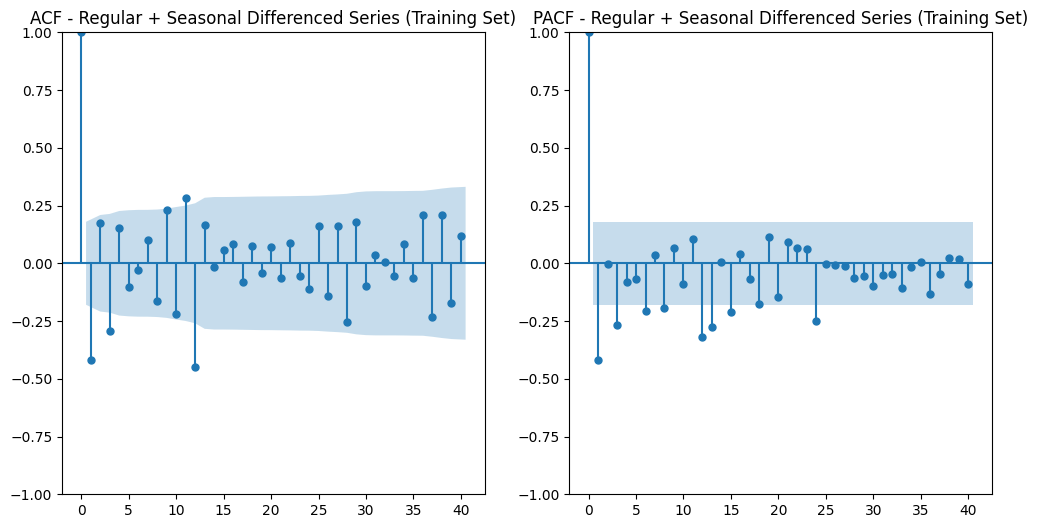

In [4]:
# Plot ACF and PACF for the series after regular and seasonal differencing
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(y_train_diff_seasonal, lags=40, ax=plt.gca())
plt.title('ACF - Regular + Seasonal Differenced Series (Training Set)')

plt.subplot(122)
plot_pacf(y_train_diff_seasonal, lags=40, ax=plt.gca())
plt.title('PACF - Regular + Seasonal Differenced Series (Training Set)')

plt.show()

In [5]:
# Based on the ACF and PACF interpretation, we are building two SARIMA models: 
# 1. AR term focused model 
# 2. MA term focused model 

##########################
# Model 1: AR Term Focused
##########################
# SARIMA model with AR terms (2, 1, 0)x(2, 1, 0, 12)
sarima_model_1 = SARIMAX(y_train, order=(2, 1, 0), seasonal_order=(2, 1, 0, 12))
results_1 = sarima_model_1.fit()

# Forecast using Model 1
forecast_1 = results_1.forecast(steps=len(y_validation))

# Print the summary of Model 1
print(results_1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06731D+00    |proj g|=  9.11568D-02

At iterate    5    f=  3.01151D+00    |proj g|=  7.18547D-02

At iterate   10    f=  3.00142D+00    |proj g|=  4.50936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.496D-06   3.001D+00
  F =   3.0014165624082900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [6]:
##########################
# Model 2: MA Term Focused
##########################
# SARIMA model with MA terms (0, 1, 2)x(0, 1, 1, 12)
sarima_model_2 = SARIMAX(y_train, order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
results_2 = sarima_model_2.fit()

# Forecast using Model 2
forecast_2 = results_2.forecast(steps=len(y_validation))

# Print the summary of Model 2
print(results_2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04706D+00    |proj g|=  9.68671D-02

At iterate    5    f=  2.98556D+00    |proj g|=  7.19897D-02

At iterate   10    f=  2.98073D+00    |proj g|=  4.03267D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.296D-05   2.981D+00
  F =   2.9807294869691954     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                 

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [7]:
# SARIMA model with AR terms (2, 1, 0)x(0, 1, 2, 12)
sarima_model_3 = SARIMAX(y_train, order=(2, 1, 0), seasonal_order=(0, 1, 2, 12))
results_3 = sarima_model_3.fit()

# Forecast using Model 3
forecast_3 = results_3.forecast(steps=len(y_validation))

# Print the summary of Model 3
print(results_3.summary())

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04820D+00    |proj g|=  5.77413D-02

At iterate    5    f=  2.99789D+00    |proj g|=  7.67569D-02

At iterate   10    f=  2.99390D+00    |proj g|=  2.05055D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   8.850D-06   2.994D+00
  F =   2.9938922346765153     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                        SARIMAX Results               

In [8]:
# SARIMA model with MA terms (0, 1, 2)x(2, 1, 0, 12)
sarima_model_4 = SARIMAX(y_train, order=(0, 1, 2), seasonal_order=(2, 1, 0, 12))
results_4 = sarima_model_4.fit()

# Forecast using Model 4
forecast_4 = results_4.forecast(steps=len(y_validation))

# Print the summary of Model 4
print(results_4.summary())

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06223D+00    |proj g|=  1.42078D-01

At iterate    5    f=  2.97917D+00    |proj g|=  1.06545D-01

At iterate   10    f=  2.96821D+00    |proj g|=  7.03015D-03

At iterate   15    f=  2.96790D+00    |proj g|=  1.16680D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.167D-06   2.968D+00
  F =   2.9679008922903960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

In [9]:
######################
# Auto ARIMA Model
######################
# Perform Auto ARIMA to automatically search for the best SARIMA model
auto_arima_model = pm.auto_arima(y_train, 
                                 seasonal=True, 
                                 m=12,  # Monthly seasonality
                                 d=1, D=1,  # Regular and seasonal differencing
                                 start_p=0, max_p=5,  # Start AR terms
                                 start_q=0, max_q=5,  # Start MA terms
                                 start_P=0, max_P=3,  # Start seasonal AR terms
                                 start_Q=0, max_Q=3,  # Start seasonal MA terms
                                 stepwise=False,  # Perform exhaustive search
                                 trace=False,  # Display search progress
                                 error_action='ignore', 
                                 suppress_warnings=True)

# Display the selected model summary
print(auto_arima_model.summary())

# Forecast using Auto ARIMA model
forecast_auto_arima = auto_arima_model.predict(n_periods=len(y_validation))

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -386.984
Date:                              Thu, 03 Oct 2024   AIC                            783.969
Time:                                      20:19:58   BIC                            797.865
Sample:                                  01-01-2010   HQIC                           789.611
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4337      0.089     -4.894      0.000      -0.607      -0.260
ma.L2         -0.10

In [10]:
######################
# Evaluation of Models
######################
# Function to calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAE, RMSE, MAPE for Model 1 (AR terms)
mae_1 = mean_absolute_error(y_validation, forecast_1)
rmse_1 = np.sqrt(mean_squared_error(y_validation, forecast_1))
mape_1 = mape(y_validation, forecast_1)

# Calculate MAE, RMSE, MAPE for Model 2 (MA terms)
mae_2 = mean_absolute_error(y_validation, forecast_2)
rmse_2 = np.sqrt(mean_squared_error(y_validation, forecast_2))
mape_2 = mape(y_validation, forecast_2)

mae_3 = mean_absolute_error(y_validation, forecast_3)
rmse_3 = np.sqrt(mean_squared_error(y_validation, forecast_3))
mape_3 = mape(y_validation, forecast_3)

mae_4 = mean_absolute_error(y_validation, forecast_4)
rmse_4 = np.sqrt(mean_squared_error(y_validation, forecast_4))
mape_4 = mape(y_validation, forecast_4)

# Calculate MAE, RMSE, MAPE for Auto ARIMA model
mae_auto = mean_absolute_error(y_validation, forecast_auto_arima)
rmse_auto = np.sqrt(mean_squared_error(y_validation, forecast_auto_arima))
mape_auto = mape(y_validation, forecast_auto_arima)

# Print the evaluation results
print(f"Model 1 (AR terms) - MAE: {mae_1}, RMSE: {rmse_1}, MAPE: {mape_1}")
print(f"Model 2 (MA terms) - MAE: {mae_2}, RMSE: {rmse_2}, MAPE: {mape_2}")
print(f"Model 3 (AR terms) - MAE: {mae_3}, RMSE: {rmse_3}, MAPE: {mape_3}")
print(f"Model 4 (MA terms) - MAE: {mae_4}, RMSE: {rmse_4}, MAPE: {mape_4}")
print(f"Auto ARIMA Model - MAE: {mae_auto}, RMSE: {rmse_auto}, MAPE: {mape_auto}")

Model 1 (AR terms) - MAE: 13.452966553604607, RMSE: 15.500322444937934, MAPE: 7.029102785512508
Model 2 (MA terms) - MAE: 6.841752645687355, RMSE: 9.36404647844308, MAPE: 3.283275197687378
Model 3 (AR terms) - MAE: 6.8366031562569, RMSE: 9.366728883237693, MAPE: 3.270696001396505
Model 4 (MA terms) - MAE: 9.513856979875607, RMSE: 11.729801567930268, MAPE: 4.77184953024963
Auto ARIMA Model - MAE: 6.814386491503464, RMSE: 9.537558928154185, MAPE: 3.2115085594768904
